In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import skutils
import copy
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Imputer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score, brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from IPython.core.pylabtools import figsize

seed = 47
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# preprocessing

big = pd.read_csv('train.csv')

big.species = big.species.astype('category')
big.species = big.species.cat.codes

def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

X, X_valid, y, y_valid = train_test_split(X, y, stratify=y, test_size=0.1)

X = X.sort_index()
y = y.sort_index()

In [3]:
# (1) + (2)

def remove_values_attribute(df, attribute, percentage):
    df = df.copy()
    df.loc[df.sample(n=int(percentage * df.shape[0]), random_state=seed).index, attribute] = None
    return df
    
def remove_values(df, percentage):
    np.random.seed(seed)
    df = df.copy()
    for i in df.sample(n=int(percentage * df.shape[0]), random_state=seed).index:
        j = np.random.randint(df.shape[1])
        df.loc[i,df.columns[j]] = None
    return df
    
low = 0.1
high = 0.6

Xn = {
    'margin5_low': {
        'X': {
            'original': remove_values_attribute(X, 'margin5', low)
        }
    },
    'margin5_high': {
        'X': {
            'original': remove_values_attribute(X, 'margin5', high)
        }
    },
    'shape1_low': {
        'X': {
            'original': remove_values_attribute(X, 'shape1', low)
        }
    },
    'shape1_high': {
        'X': {
            'original': remove_values_attribute(X, 'shape1', high)
        }
    },
    'all_low': {
        'X': {
            'original': remove_values(X, low)
        }
    },
    'all_high':{
        'X': {
            'original': remove_values(X, high)
        }
    },
}

In [4]:
# (3)

strategies = ['ignore', 'totalmean', 'classmean']

def ignore_missing(df):
    return df.dropna(axis=1)

def replace_by_totalmean(df):
    return pd.DataFrame(Imputer(axis=1).fit_transform(df))

def replace_by_classmean(X, y):    
    df = pd.concat([y,X], axis=1)
    
    for col in X.columns[X.isnull().any()].tolist():
        grouped = df.groupby(['species'])[col].mean().to_frame().reset_index()
        
        df['index'] = df.index
        df = df.merge(grouped, left_on='species', right_on='species', how='inner')
        df = df.set_index('index')
        df = df.sort_index()
        df.index.name = None

        df[col] = df[col + '_x']
        df[col] = df[col].fillna(df[col + '_y']).fillna(0) # zero if classmean is nan
        df = df.drop([col + '_x', col + '_y'], axis=1)        
    
    return df.drop('species', axis=1)

for k in Xn.keys():
    Xi = Xn[k]['X']
    Xi['ignore'] = ignore_missing(Xi['original'])
    Xi['totalmean'] = replace_by_totalmean(Xi['original'])
    Xi['classmean'] = replace_by_classmean(Xi['original'], y)

In [5]:
# Train

measures = {
    'pre': precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score,
}

classifiers = {
    "LR": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1))
            ]) },
}

def train(X, y, classifiers, size):
    sss = StratifiedShuffleSplit(10, test_size=size, random_state=seed)
    clfs = copy.deepcopy(classifiers)
    
    for clf in clfs.keys(): 
        c = clfs[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        for clf in clfs.keys():                    
            c = clfs[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = np.asarray(c["f"].predict(X_test))

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc' and meas != 'br'):
                    c[meas].append(m(y_test, y_pred, average='macro'))
                elif (meas == 'll'):
                    c[meas].append(m(y_test, y_pred, labels=y_test))
                else:
                    c[meas].append(m(y_test, y_pred))
    
    return clfs

result = train(X, y, classifiers, 0.3)
                       
for k in Xn.keys():
    Xi = Xn[k]['X']
    results = {}
    for strategy in strategies:
        results[strategy] = train(Xi[strategy], y, classifiers, 0.3)
    Xn[k]['results'] = results

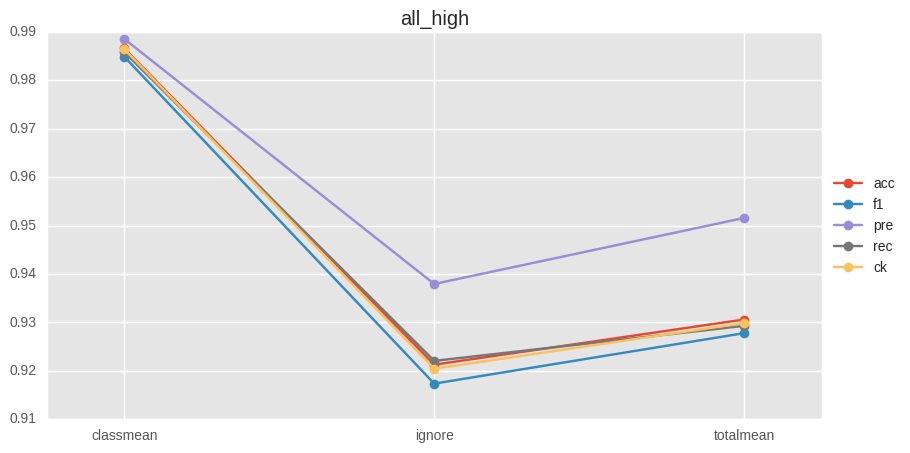

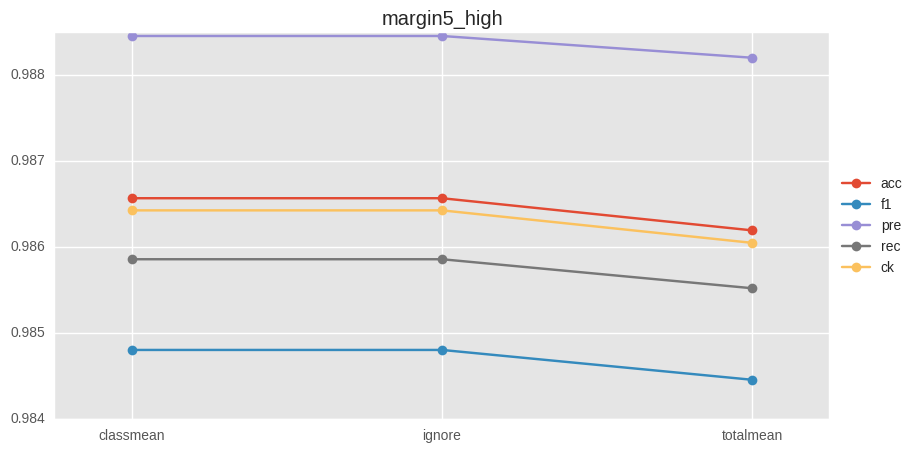

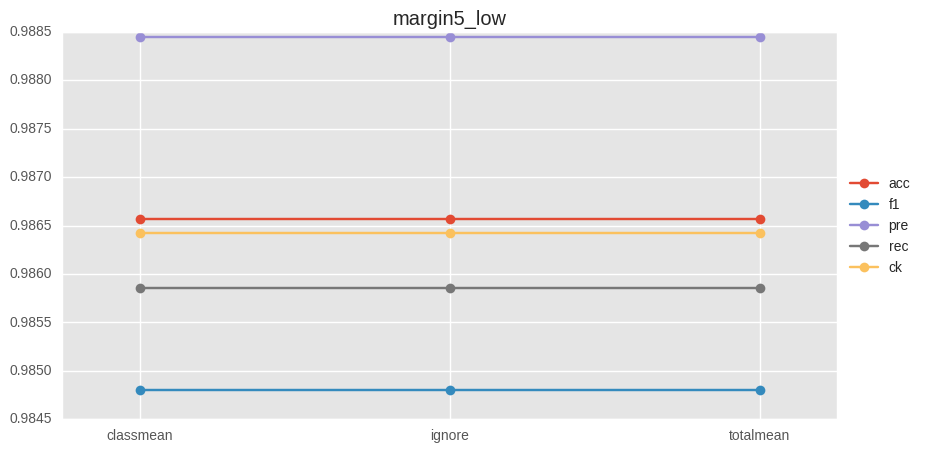

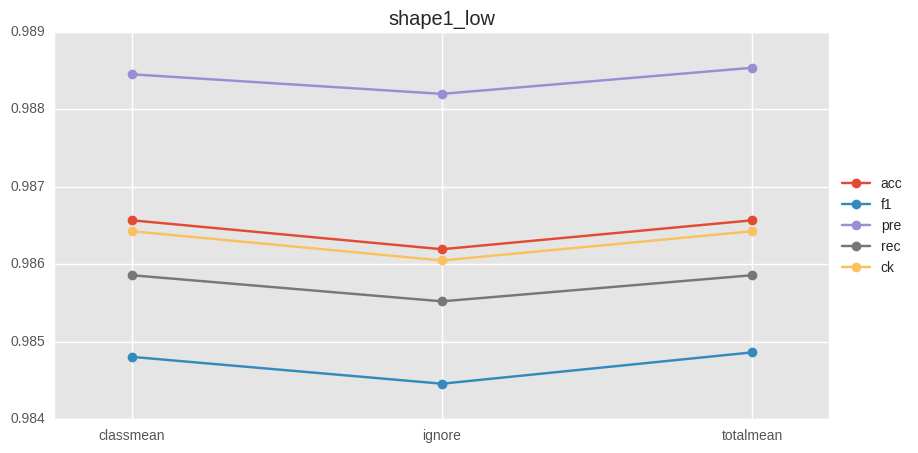

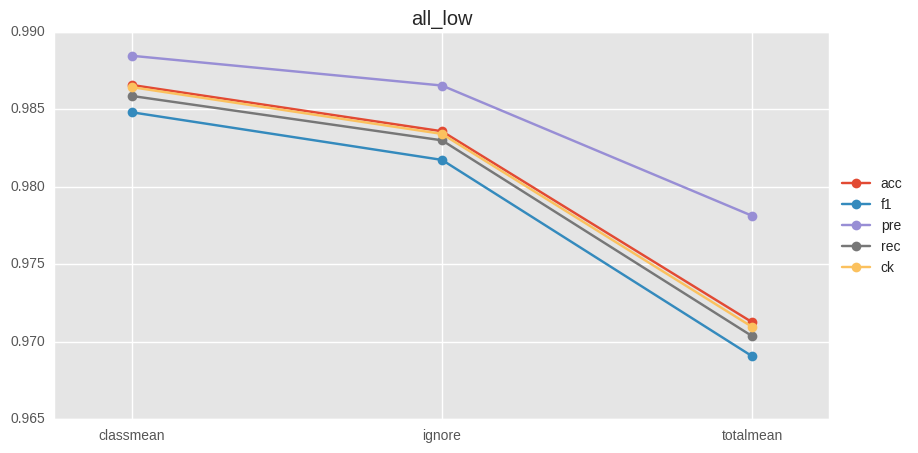

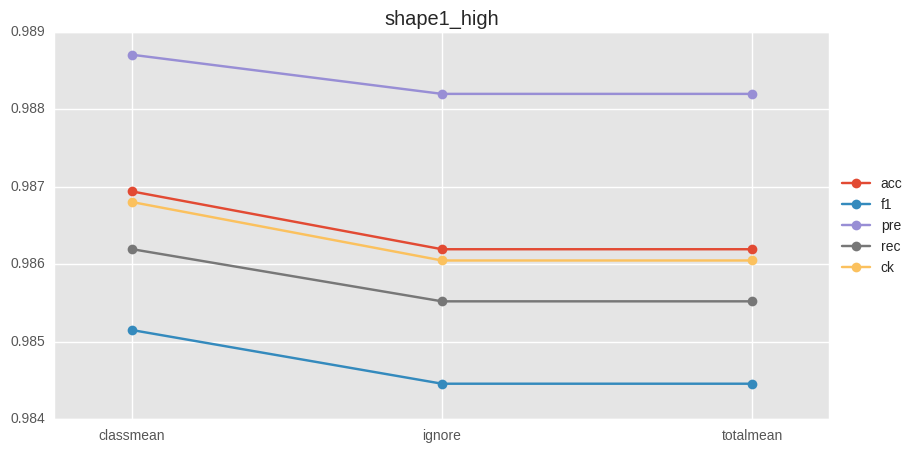

In [6]:
def plot_param3(cl, column):
    results = pd.DataFrame(columns=measures)

    for strategy in cl.keys():
        for model in cl[strategy].keys():
            res = [np.mean(cl[strategy][model][measure]) for measure in measures.keys()]
            results.loc[strategy] = res

    results = results.sort_index()
    
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.title(column)

    plt.savefig("plots/" + column + "_missing_values.png")
    plt.show()
    

for k in Xn.keys():
    Xi = Xn[k]['results']
    plot_param3(Xi, k)

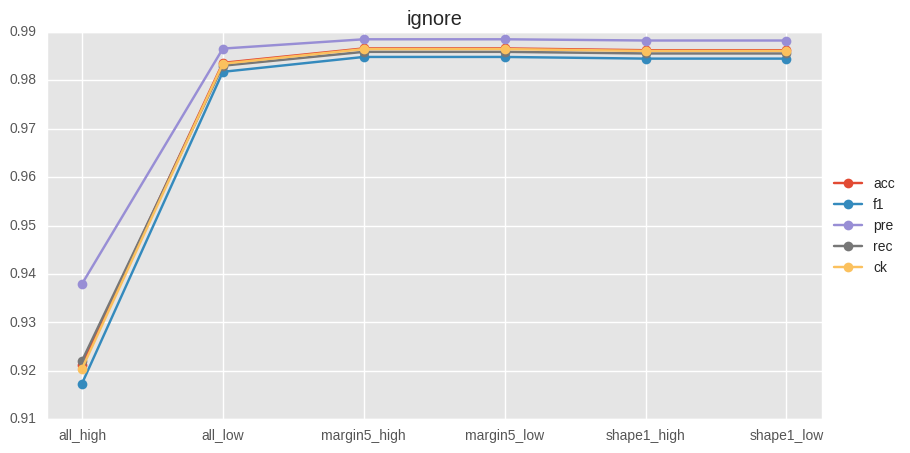

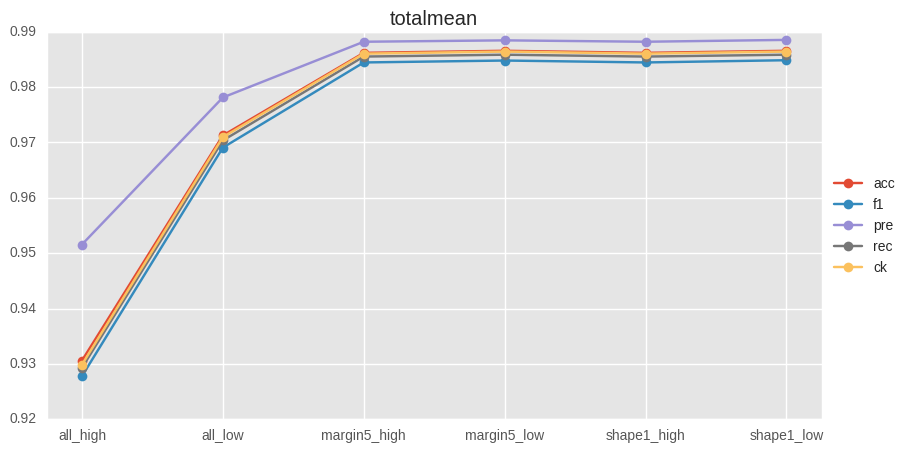

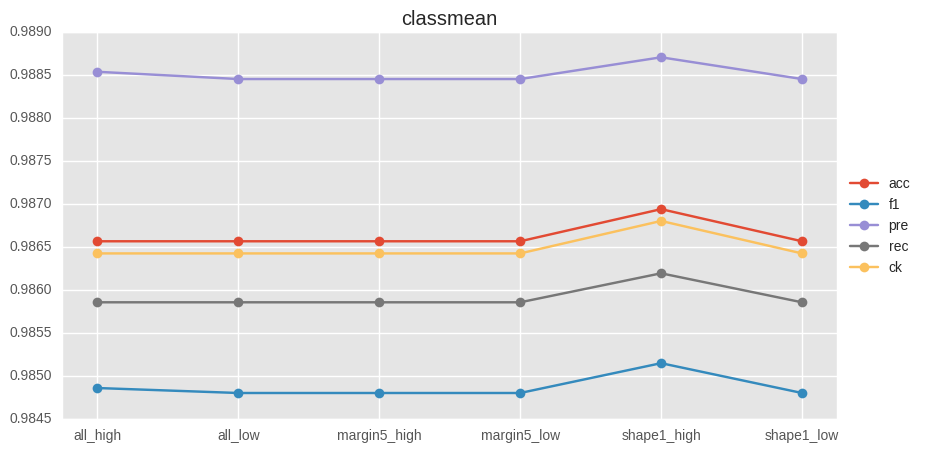

In [7]:
def plot_param4(cl, strategy):
    results = pd.DataFrame(columns=measures)

    for missingVal in cl.keys():
        res = cl[missingVal]['results'][strategy]
        for model in res.keys():
            results.loc[missingVal] = [np.mean(res[model][measure]) for measure in measures.keys()]

    results = results.sort_index()
    
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.title(strategy)

    plt.savefig("plots/" + strategy + "_missing_values.png")
    plt.show()

for strategy in strategies:
    plot_param4(Xn, strategy)

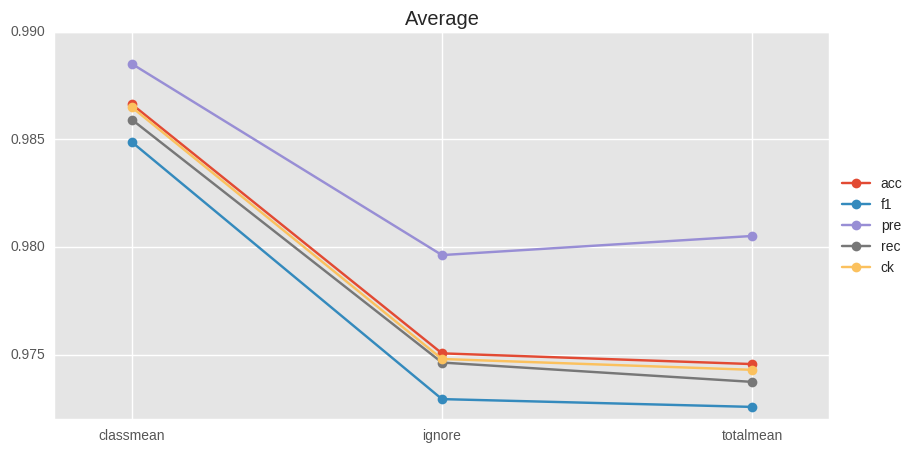

In [8]:
def plot_param5(cl):
    results = pd.DataFrame(columns=measures)

    res = {}
    for strategy in strategies:
        res[strategy] = {}
        for measure in measures.keys():
            res[strategy][measure] = []

    for k in cl.keys():
        Xi = cl[k]['results']
        for strategy in Xi.keys():
            for model in Xi[strategy].keys():
                for measure in measures.keys():
                    res[strategy][measure] = res[strategy][measure] + Xi[strategy][model][measure]

    for strategy in strategies:
        results.loc[strategy] = [(np.mean(res[strategy][measure])) for measure in measures.keys()]

    results = results.sort_index()
    
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.title('Average')

    plt.savefig("plots/average_missing_values.png")
    plt.show()

plot_param5(Xn)